In [832]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [833]:
# Reading and Renaming

df_FF3 = pd.read_csv("F-F_Research_Data_Factors_daily_new.txt", delimiter="\t")
df_Target = pd.read_csv("Target Stock Returns.txt", delimiter="\t")

df_FF3.columns = ["MM/DD/YYYY", 
                  "E[R_Mkt]-R_f",  
                  "SMB", 
                  "HML",
                  "R_f"]

df_Target.columns = ["Useless",
                     "MM/DD/YYYY",
                     "Company Name",
                     "E[R_Tgt]"]

In [834]:
# Setting Date as MM/DD/YYYY

df_FF3['Date'] = pd.to_datetime(df_FF3['MM/DD/YYYY'].astype(str), format='%Y%m%d')
df_Target['Date'] = pd.to_datetime(df_Target['MM/DD/YYYY'], format='%m/%d/%Y')

df_FF3['MM/DD/YYYY'] = df_FF3['Date'].dt.strftime('%m/%d/%Y')
df_Target['MM/DD/YYYY'] = df_Target['Date'].dt.strftime('%m/%d/%Y')


In [835]:
# Dropping irrelavant Coloumns

df_FF3.drop(columns="Date", axis=1, inplace=True)
df_Target.drop(columns=["Date", "Useless", "Company Name"], axis=1, inplace=True)

In [836]:
# Coverting the data in the same units - Decimals

for i in range(1, len(df_FF3.columns)):
    df_FF3[df_FF3.columns[i]] = pd.to_numeric(df_FF3[df_FF3.columns[i]])

for i in range(1, len(df_Target.columns)):
    df_Target[df_Target.columns[i]] = pd.to_numeric(df_Target[df_Target.columns[i]])

df_FF3.iloc[:, 1:]=df_FF3.iloc[:, 1:]/100
# df_Target.iloc[:, 1:]=df_Target.iloc[:, 1:]/100

In [837]:
df_FF3

,MM/DD/YYYY,E[R_Mkt]-R_f,SMB,HML,R_f
0,07/01/1926,0.0009,-0.0025,-0.0027,0.0001
1,07/02/1926,0.0045,-0.0033,-0.0006,0.0001
2,07/06/1926,0.0017,0.0030,-0.0039,0.0001
3,07/07/1926,0.0009,-0.0058,0.0002,0.0001
4,07/08/1926,0.0022,-0.0038,0.0019,0.0001
...,...,...,...,...,...
26061,08/25/2025,-0.0048,-0.0063,0.0045,0.0002
26062,08/26/2025,0.0043,0.0025,0.0013,0.0002
26063,08/27/2025,0.0024,0.0040,0.0027,0.0002
26064,08/28/2025,0.0035,-0.0015,-0.0052,0.0002


In [838]:
df_Target

,MM/DD/YYYY,E[R_Tgt]
0,12/31/2021,-0.002027
1,01/03/2022,0.002204
2,01/04/2022,0.009571
3,01/05/2022,-0.022676
4,01/06/2022,0.010880
...,...,...
749,12/24/2024,0.003639
750,12/26/2024,0.030136
751,12/27/2024,-0.006525
752,12/30/2024,-0.003321


# CAPM

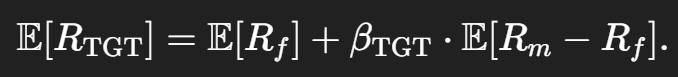

In [839]:
# Getting a Clean Dataset with relevant Coloumns

# 1) Make a clean datetime key in each frame
ff3 = df_FF3.rename(columns={'MM/DD/YYYY': 'Date'})[['Date', 'E[R_Mkt]-R_f', 'R_f']].copy()
tgt = df_Target.rename(columns={'MM/DD/YYYY': 'Date'})[['Date', 'E[R_Tgt]']].copy()

ff3['Date'] = pd.to_datetime(ff3['Date'], format='%m/%d/%Y')
tgt['Date'] = pd.to_datetime(tgt['Date'], format='%m/%d/%Y')

# 2) Inner join on dates (keeps only the overlapping trading days)
panel = tgt.merge(ff3, on='Date', how='inner').sort_values('Date').reset_index(drop=True)

# 3) Column name from Date to MM/DD/YYYY
panel['MM/DD/YYYY'] = panel['Date'].dt.strftime('%m/%d/%Y')
panel.drop(columns="Date", axis=1, inplace=True)
panel = panel[['MM/DD/YYYY', 'E[R_Tgt]', 'E[R_Mkt]-R_f', 'R_f']]
panel_new = panel.copy()

In [840]:
panel

,MM/DD/YYYY,E[R_Tgt],E[R_Mkt]-R_f,R_f
0,12/31/2021,-0.002027,-0.0031,0.0000
1,01/03/2022,0.002204,0.0072,0.0000
2,01/04/2022,0.009571,-0.0027,0.0000
3,01/05/2022,-0.022676,-0.0226,0.0000
4,01/06/2022,0.010880,0.0000,0.0000
...,...,...,...,...
749,12/24/2024,0.003639,0.0111,0.0002
750,12/26/2024,0.030136,0.0001,0.0002
751,12/27/2024,-0.006525,-0.0117,0.0002
752,12/30/2024,-0.003321,-0.0109,0.0002


In [841]:
# Beta of Traget = Cov[(Target Excess Return -R_f), Market Excess Return)]/Var(Market Excess Return)

# 1) Excess return for Target
panel['E[R_Tgt]-R_f'] = panel['E[R_Tgt]'] - panel['R_f']

# Daily sample covariance (ddof=1) and variance over the same period
cov_excess = panel['E[R_Tgt]-R_f'].cov(panel['E[R_Mkt]-R_f'])      # Cov( Target excess, Market excess )
var_mkt   = panel['E[R_Mkt]-R_f'].var()                        # Var( Market excess )

# Optional: CAPM beta and annualization
beta = cov_excess / var_mkt
print('Beta:', beta)

Beta: 0.9819024329542857


In [842]:
# Beta of Traget = Cov[(Target Returns), Market Returns)]/Var(Market Returns)

# 1) Excess return for Target
panel_new['E[R_Mkt]'] = panel_new['E[R_Mkt]-R_f'] + panel_new['R_f']

# Daily sample covariance (ddof=1) and variance over the same period
cov_excess_new = panel_new['E[R_Tgt]'].cov(panel_new['E[R_Mkt]'])      # Cov( Target, Market)
var_mkt_new   = panel_new['E[R_Mkt]'].var()                        # Var( Market)

# Optional: CAPM beta and annualization
beta_new = cov_excess_new / var_mkt_new
print('Beta:', beta_new)

Beta: 0.9818543000106127


In [843]:
# Putting the Beta Value in the CAPM Equation

# Extracting R_f and E[R_Mkt]-R_f data from FF3 Dataset from 1926 to 2024
rf = df_FF3['R_f'].astype(float)
r_mkt_minus_rf = df_FF3["E[R_Mkt]-R_f"].astype(float)

# Daily average of R_f and E[R_Mkt]-R_f
rf_daily_mean = rf.mean()
r_mkt_minus_rf_daily_mean = r_mkt_minus_rf.mean()

# Annualizing the long averge of R_f and E[R_Mkt]-R_f
Annual_rf_daily_mean = pow((1+rf_daily_mean), 252) - 1
Annual_r_mkt_minus_rf_daily_mean = pow((1+r_mkt_minus_rf_daily_mean), 252) - 1


print("Average daily R_f:", rf_daily_mean)
print("Annulaised Average R_f:", Annual_rf_daily_mean*100)

print("Average daily R_Mkt - R_f:", r_mkt_minus_rf_daily_mean)
print("Annulaised Average R_Mkt - R_f:", Annual_r_mkt_minus_rf_daily_mean*100)

Average daily R_f: 0.0001191744034374281
Annulaised Average R_f: 3.0485613228284913
Average daily R_Mkt - R_f: 0.00030830967543926956
Annulaised Average R_Mkt - R_f: 8.077898523302828


In [844]:
# Calculating Cost of Equity for Target (Daily)
E_R_tgt_daily = rf_daily_mean + beta * r_mkt_minus_rf_daily_mean
print("Daily E[R_Tgt]:", E_R_tgt_daily)

# Calculating Cost of Equity for Target (Annualized)
Annual_E_R_tgt_daily = pow((1+E_R_tgt_daily), 252) - 1
print("Annulized E[R_Tgt]:",Annual_E_R_tgt_daily*100)

Daily E[R_Tgt]: 0.00042190442385459304
Annulized E[R_Tgt]: 11.215268459879146


alpha(daily)=-0.000674, beta=0.981902432954286, R^2=0.217, n=754


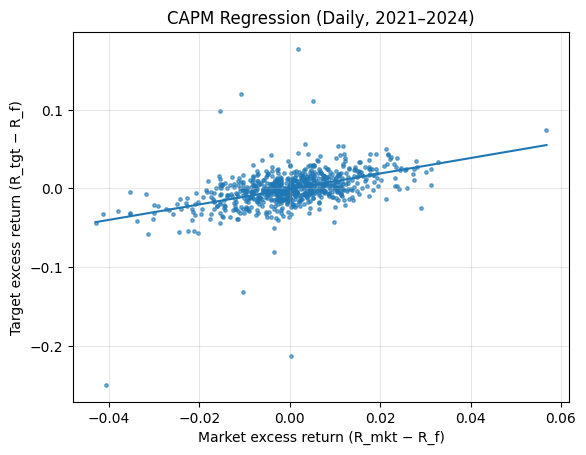

                            OLS Regression Results                            
Dep. Variable:             excess_tgt   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     101.1
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           2.07e-22
Time:                        22:24:45   Log-Likelihood:                 1826.9
No. Observations:                 754   AIC:                            -3650.
Df Residuals:                     752   BIC:                            -3640.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.882      0.3

In [845]:
# This is using the regression queation we have essentially plotted market excess return E[R_Mkt]-R_f with Target Excess Return E[R_Tgt]-R_f from 2021 to 2024. This is important since we can't different time frames in the OLS function. But now that we have our
# beta we can go ahead and put it in our CAPM and find the expected target return where R_f and E[R_Mkt - R_f] would be long running average/mean from 1926 to 2024.

import pandas as pd, numpy as np, statsmodels.api as sm, matplotlib.pyplot as plt

# Use your merged daily frame `panel` with columns:
# ['MM/DD/YYYY','E[R_Tgt]','E[R_mkt]-R_f','R_f']

df = panel.copy()
df['Date'] = pd.to_datetime(df['MM/DD/YYYY'], format='%m/%d/%Y')
df = df[(df['Date'] >= '2021-01-01') & (df['Date'] <= '2024-12-31')].sort_values('Date')

# Build excess returns
df['excess_tgt'] = df['E[R_Tgt]'].astype(float) - df['R_f'].astype(float)
df['excess_mkt'] = df['E[R_Mkt]-R_f'].astype(float)

S = df[['excess_tgt','excess_mkt']].dropna()

# CAPM: (R_tgt - R_f) = alpha + beta*(R_mkt - R_f) + ε
X = sm.add_constant(S['excess_mkt'])
y = S['excess_tgt']
res = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})  # Newey–West SEs

alpha, beta = res.params['const'], res.params['excess_mkt']
print(f"alpha(daily)={alpha:.6f}, beta={beta:.15f}, R^2={res.rsquared:.3f}, n={len(S)}")

# Plot: scatter + fitted line
plt.figure()
plt.scatter(S['excess_mkt'], S['excess_tgt'], s=6, alpha=0.6)
x = np.linspace(S['excess_mkt'].min(), S['excess_mkt'].max(), 200)
plt.plot(x, alpha + beta*x)
plt.xlabel('Market excess return (R_mkt − R_f)')
plt.ylabel('Target excess return (R_tgt − R_f)')
plt.title('CAPM Regression (Daily, 2021–2024)')
plt.grid(True, alpha=0.3)
plt.show()

print(res.summary())

# Beta: 0.9819024329542857


In [846]:
import pandas as pd

# Ensure a real datetime key
ff3 = df_FF3.copy()
ff3['Date'] = pd.to_datetime(ff3['MM/DD/YYYY'], errors='coerce')

# Filter from 1949-01-01 (inclusive) to the end
ff3_49 = (ff3[ff3['Date'] >= '1949-12-31']
            .sort_values('Date')
            .reset_index(drop=True))


# # Long-run daily means on the 1949+ subset
# mkt_col = 'E[R_Mkt]-R_f' if 'E[R_Mkt]-R_f' in ff3_49.columns else 'E[R_mkt]-R_f'

mu_rf_d  = ff3_49['R_f'].astype(float).mean()
mu_mkt_d = ff3_49['E[R_Mkt]-R_f'].astype(float).mean()
# mu_smb_d = ff3_49['SMB'].astype(float).mean()
# mu_hml_d = ff3_49['HML'].astype(float).mean()

# # E[R_Tgt] = R_f + beta_m * E[R_Mkt - R_f] + s_sml * SML + H_hml * HML
E_R_tgt_d = mu_rf_d + beta*mu_mkt_d
print("CAPM expected Target return (daily):", E_R_tgt_d)

# # Annualise it
Annual_E_R_tgt_daily_CAPM = pow((1+E_R_tgt_d), 252) - 1
print("Annulized E[R_Tgt] using CAPM: ",Annual_E_R_tgt_daily_CAPM*100)


CAPM expected Target return (daily): 0.000473143012042227
Annulized E[R_Tgt] using CAPM:  12.659954209038649


In [847]:
# DDM usung CAPM:

P_o_CAPM = 2/Annual_E_R_tgt_daily_CAPM

print("DDM using CAPM {:,.02f}".format(P_o_CAPM))

DDM using CAPM 15.80


# FF3

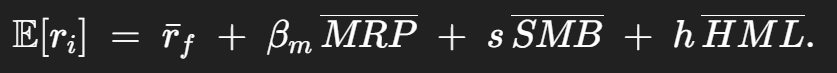

In [848]:
df_Target_new = df_Target.copy()
df_FF3_new = df_FF3.copy()

In [849]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

df_FF3_new['MM/DD/YYYY'] = pd.to_datetime(df_FF3_new['MM/DD/YYYY'], format='%m/%d/%Y')
df_Target_new['MM/DD/YYYY'] = pd.to_datetime(df_Target_new['MM/DD/YYYY'], format='%m/%d/%Y')

# Inner join on overlapping trading days (2021–2024 for Target)
panel_new = (df_Target_new[['MM/DD/YYYY','E[R_Tgt]']]
         .merge(df_FF3_new[['MM/DD/YYYY','E[R_Mkt]-R_f','SMB','HML','R_f']], on='MM/DD/YYYY', how='inner')
         .sort_values('MM/DD/YYYY')
         .reset_index(drop=True))

panel_new

,MM/DD/YYYY,E[R_Tgt],E[R_Mkt]-R_f,SMB,HML,R_f
0,2021-12-31,-0.002027,-0.0031,0.0005,0.0052,0.0000
1,2022-01-03,0.002204,0.0072,0.0035,0.0077,0.0000
2,2022-01-04,0.009571,-0.0027,-0.0081,0.0364,0.0000
3,2022-01-05,-0.022676,-0.0226,-0.0146,0.0258,0.0000
4,2022-01-06,0.010880,0.0000,0.0021,0.0176,0.0000
...,...,...,...,...,...,...
749,2024-12-24,0.003639,0.0111,-0.0009,-0.0006,0.0002
750,2024-12-26,0.030136,0.0001,0.0104,-0.0018,0.0002
751,2024-12-27,-0.006525,-0.0117,-0.0065,0.0057,0.0002
752,2024-12-30,-0.003321,-0.0109,0.0013,0.0074,0.0002


α (daily)   : -0.000615  t=-0.80
β_m (Mkt-Rf):  0.9599  t=8.44
s (SMB)     :  0.3605  t=2.95
h (HML)     :  0.1770  t=1.98
R²=0.231   n=754
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     51.09
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           4.71e-30
Time:                        22:24:45   Log-Likelihood:                 1833.6
No. Observations:                 754   AIC:                            -3659.
Df Residuals:                     750   BIC:                            -3641.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025  

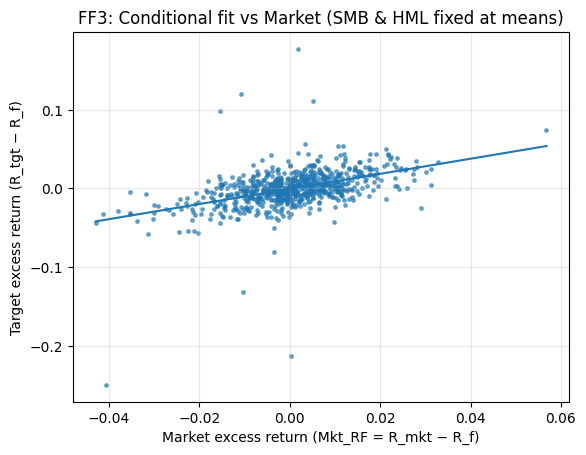

In [850]:
# Force numeric
for c in ['E[R_Tgt]','E[R_Mkt]-R_f','SMB','HML','R_f']:
    panel_new[c] = pd.to_numeric(panel_new[c], errors='coerce')
panel = panel.dropna()

# --- 3) FF3 regression: (R_tgt - R_f) = α + b*Mkt_RF + s*SMB + h*HML + ε ---
y = panel_new['E[R_Tgt]'] - panel['R_f']                 # Target excess return
X = panel_new[['E[R_Mkt]-R_f','SMB','HML']]
X = sm.add_constant(X)                            # intercept -> Jensen's alpha
res = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':5})  # Newey–West SEs

alpha  = res.params['const']
beta_m = res.params['E[R_Mkt]-R_f']
s_smb  = res.params['SMB']
h_hml  = res.params['HML']

print(f"α (daily)   : {alpha: .6f}  t={res.tvalues['const']:.2f}")
print(f"β_m (Mkt-Rf): {beta_m: .4f}  t={res.tvalues['E[R_Mkt]-R_f']:.2f}")
print(f"s (SMB)     : {s_smb: .4f}  t={res.tvalues['SMB']:.2f}")
print(f"h (HML)     : {h_hml: .4f}  t={res.tvalues['HML']:.2f}")
print(f"R²={res.rsquared:.3f}   n={len(panel)}")

print(res.summary())

# Fix SMB and HML at their sample means for the plotting line
smb_bar = panel_new['SMB'].mean()
hml_bar = panel_new['HML'].mean()

# Scatter vs market excess and the conditional fitted line
plt.figure()
plt.scatter(panel_new['E[R_Mkt]-R_f'], y, s=6, alpha=0.6)

xgrid = np.linspace(panel_new['E[R_Mkt]-R_f'].min(), panel_new['E[R_Mkt]-R_f'].max(), 200)
ygrid = alpha + beta_m*xgrid + s_smb*smb_bar + h_hml*hml_bar

plt.plot(xgrid, ygrid)
plt.xlabel('Market excess return (Mkt_RF = R_mkt − R_f)')
plt.ylabel('Target excess return (R_tgt − R_f)')
plt.title('FF3: Conditional fit vs Market (SMB & HML fixed at means)')
plt.grid(True, alpha=0.3)
plt.show()


In [851]:
# Long-run daily factor means from full FF3 history
mu_rf_d   = df_FF3_new['R_f'].astype(float).mean()
mu_mkt_d  = df_FF3_new['E[R_Mkt]-R_f'].astype(float).mean()
mu_smb_d  = df_FF3_new['SMB'].astype(float).mean()
mu_hml_d  = df_FF3_new['HML'].astype(float).mean()

# E[R_Tgt] = R_f + beta_m * E[R_Mkt - R_f] + s_sml * SML + H_hml * HML
E_R_tgt_d = mu_rf_d + beta_m*mu_mkt_d + s_smb*mu_smb_d + h_hml*mu_hml_d
print("FF3 expected Target return (daily):", E_R_tgt_d)

# Annualise it
Annual_E_R_tgt_daily_FF3 = pow((1+E_R_tgt_d), 252) - 1
print("Annulized E[R_Tgt] using FF3:",Annual_E_R_tgt_daily_FF3*100)

FF3 expected Target return (daily): 0.00045525341533966384
Annulized E[R_Tgt] using FF3: 12.153440747018873


In [852]:
import pandas as pd

# Ensure a real datetime key
ff3 = df_FF3_new.copy()
ff3['Date'] = pd.to_datetime(ff3['MM/DD/YYYY'], errors='coerce')

# Filter from 1949-01-01 (inclusive) to the end
ff3_49 = (ff3[ff3['Date'] >= '1949-12-31']
            .sort_values('Date')
            .reset_index(drop=True))

# Long-run daily means on the 1949+ subset
mkt_col = 'E[R_Mkt]-R_f' if 'E[R_Mkt]-R_f' in ff3_49.columns else 'E[R_mkt]-R_f'

mu_rf_d  = ff3_49['R_f'].astype(float).mean()
mu_mkt_d = ff3_49[mkt_col].astype(float).mean()
mu_smb_d = ff3_49['SMB'].astype(float).mean()
mu_hml_d = ff3_49['HML'].astype(float).mean()

# E[R_Tgt] = R_f + beta_m * E[R_Mkt - R_f] + s_sml * SML + H_hml * HML
E_R_tgt_d = mu_rf_d + beta_m*mu_mkt_d + s_smb*mu_smb_d + h_hml*mu_hml_d
print("FF3 expected Target return (daily):", E_R_tgt_d)

# Annualise it
Annual_E_R_tgt_daily_FF3 = pow((1+E_R_tgt_d), 252) - 1
print("Annulized E[R_Tgt] using FF3:",Annual_E_R_tgt_daily_FF3*100)


FF3 expected Target return (daily): 0.0005011056867411618
Annulized E[R_Tgt] using FF3: 13.456237529518988


# DDM usung FF3:

P_o = 2/Annual_E_R_tgt_daily_FF3

print("DDM using CAPM {:,.02f}".format(P_o_CAPM))
print("DDM using FF3 ${:,.02f}".format(P_o))